In [94]:
# @title Cell 1: Cài đặt, Import thư viện và Kết nối Google Drive
# --- 1. Cài đặt thư viện ---
# Đảm bảo các thư viện cần thiết như xgboost và imblearn được cài đặt
!pip install xgboost imbalanced-learn -q
!pip install lightgbm -q

# --- 2. Import các thư viện cần thiết ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Metrics and Visualization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- 3. Cài đặt hiển thị và kết nối Drive ---
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-deep')
drive.mount('/content/drive')

print("\nHoàn tất: Môi trường đã sẵn sàng!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Hoàn tất: Môi trường đã sẵn sàng!


In [95]:
# @title Cell 2: Tải và Đọc Dữ liệu
# --- 1. Giải nén file từ Google Drive ---
# Đường dẫn có thể thay đổi tùy vào vị trí lưu file của bạn
zip_file_path = '/content/drive/MyDrive/Machine Learning/archive.zip'
destination_folder = '/content/stroke_data/'
!unzip -o "{zip_file_path}" -d "{destination_folder}"

# --- 2. Đọc file CSV vào DataFrame ---
csv_file_path = '/content/stroke_data/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(csv_file_path)

print("Đã tải và đọc dữ liệu thành công.")

Archive:  /content/drive/MyDrive/Machine Learning/archive.zip
  inflating: /content/stroke_data/healthcare-dataset-stroke-data.csv  
Đã tải và đọc dữ liệu thành công.


In [96]:
# @title Cell 3: Bối cảnh và Tuyên bố Vấn đề
print("""
BÀI TOÁN: Dự đoán nguy cơ đột quỵ dựa trên các yếu tố lâm sàng

BỐI CẢNH Y TẾ:
- Đột quỵ là một trong những nguyên nhân gây tử vong và tàn tật hàng đầu trên thế giới.
- Việc phát hiện sớm các yếu tố nguy cơ có thể giúp can thiệp kịp thời, giảm thiểu đáng kể rủi ro và hậu quả.

Ý NGHĨA THỰC TIỄN:
- Xây dựng một công cụ hỗ trợ các chuyên gia y tế trong việc sàng lọc và chẩn đoán sớm.
- Nâng cao nhận thức về các yếu tố nguy cơ, góp phần vào y tế dự phòng.
- Giảm gánh nặng chi phí điều trị và chăm sóc dài hạn cho bệnh nhân và xã hội.

MỤC TIÊU DỰ ÁN:
- Xây dựng và đánh giá các mô hình học máy để dự đoán khả năng một người bị đột quỵ.
- Xác định các yếu tố ảnh hưởng quan trọng nhất đến nguy cơ đột quỵ.
- Do tính chất bài toán y tế (bỏ sót bệnh nhân nguy hiểm hơn chẩn đoán nhầm), mô hình cần ưu tiên chỉ số Recall và F1-Score cho lớp "Đột quỵ".
""")


BÀI TOÁN: Dự đoán nguy cơ đột quỵ dựa trên các yếu tố lâm sàng

BỐI CẢNH Y TẾ:
- Đột quỵ là một trong những nguyên nhân gây tử vong và tàn tật hàng đầu trên thế giới.
- Việc phát hiện sớm các yếu tố nguy cơ có thể giúp can thiệp kịp thời, giảm thiểu đáng kể rủi ro và hậu quả.

Ý NGHĨA THỰC TIỄN:
- Xây dựng một công cụ hỗ trợ các chuyên gia y tế trong việc sàng lọc và chẩn đoán sớm.
- Nâng cao nhận thức về các yếu tố nguy cơ, góp phần vào y tế dự phòng.
- Giảm gánh nặng chi phí điều trị và chăm sóc dài hạn cho bệnh nhân và xã hội.

MỤC TIÊU DỰ ÁN:
- Xây dựng và đánh giá các mô hình học máy để dự đoán khả năng một người bị đột quỵ.
- Xác định các yếu tố ảnh hưởng quan trọng nhất đến nguy cơ đột quỵ.
- Do tính chất bài toán y tế (bỏ sót bệnh nhân nguy hiểm hơn chẩn đoán nhầm), mô hình cần ưu tiên chỉ số Recall và F1-Score cho lớp "Đột quỵ".



In [97]:
# @title Cell 4: Khám phá Dữ liệu Ban đầu (EDA)
print("--- 1. 5 dòng dữ liệu đầu tiên ---")
display(df.head())

print("\n" + "="*50 + "\n")
print("--- 2. Thông tin tổng quan về các cột ---")
df.info()

print("\n" + "="*50 + "\n")
print("--- 3. Thống kê mô tả cho các cột số ---")
display(df.describe())

print("\n" + "="*50 + "\n")
print("--- 4. Kiểm tra số lượng giá trị thiếu (NaN) ---")
print(df.isnull().sum())

--- 1. 5 dòng dữ liệu đầu tiên ---


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1




--- 2. Thông tin tổng quan về các cột ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


--- 3. Thống kê mô tả cho các cột số ---


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000




--- 4. Kiểm tra số lượng giá trị thiếu (NaN) ---
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [98]:
# @title Cell 5: Tiền xử lý - Làm sạch Dữ liệu
# --- 1. Xử lý giá trị thiếu cho cột 'bmi' ---
# Phân phối của BMI có thể bị lệch, do đó sử dụng median (trung vị) là một lựa chọn an toàn để điền giá trị thiếu.
bmi_median = df['bmi'].median()
df['bmi'] = df['bmi'].fillna(bmi_median) # Sửa lỗi cảnh báo FutureWarning
print(f"Đã điền các giá trị thiếu trong cột 'bmi' bằng giá trị median: {bmi_median:.2f}")

# --- 2. Loại bỏ cột không cần thiết ('id') ---
# Cột 'id' không mang thông tin dự đoán nên được loại bỏ.
df = df.drop('id', axis=1)
print("Đã loại bỏ cột 'id'.")

# --- 3. Xử lý giá trị 'Other' trong cột 'gender' ---
# Có một bản ghi với giới tính là 'Other', số lượng quá ít để huấn luyện, nên ta loại bỏ.
df = df[df['gender'] != 'Other']
print("Đã loại bỏ hàng có giá trị 'gender' là 'Other'.")

print(f"\nSố lượng dòng dữ liệu sau khi làm sạch: {len(df)}")
print(f"Số giá trị thiếu còn lại: {df.isnull().sum().sum()}")

Đã điền các giá trị thiếu trong cột 'bmi' bằng giá trị median: 28.10
Đã loại bỏ cột 'id'.
Đã loại bỏ hàng có giá trị 'gender' là 'Other'.

Số lượng dòng dữ liệu sau khi làm sạch: 5109
Số giá trị thiếu còn lại: 0


/tmp/ipython-input-3432475848.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Không Đột quỵ', 'Đột quỵ'])


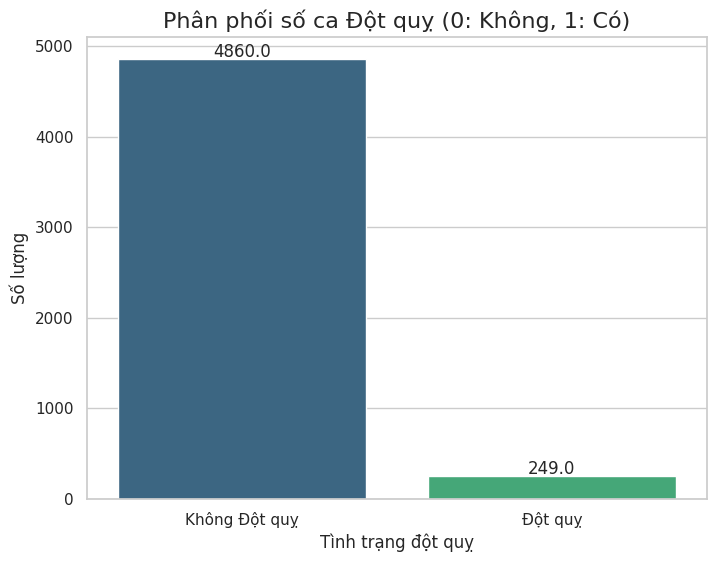

Tỷ lệ các lớp:
stroke
0    95.126248
1     4.873752
Name: proportion, dtype: float64

=> Nhận xét: Dữ liệu rất mất cân bằng. Đây là điểm cần xử lý cẩn thận trong bước xây dựng mô hình.


In [99]:
# @title Cell 6: EDA - Kiểm tra sự Mất cân bằng Dữ liệu
plt.figure(figsize=(8, 6))
# Sửa lỗi cảnh báo bằng cách gán hue='stroke'
ax = sns.countplot(data=df, x='stroke', hue='stroke', palette='viridis', legend=False)
plt.title('Phân phối số ca Đột quỵ (0: Không, 1: Có)', fontsize=16)
plt.xlabel('Tình trạng đột quỵ', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
ax.set_xticklabels(['Không Đột quỵ', 'Đột quỵ'])

# Hiển thị số lượng trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

plt.show()

# In ra tỷ lệ phần trăm
print("Tỷ lệ các lớp:")
print(df['stroke'].value_counts(normalize=True) * 100)
print("\n=> Nhận xét: Dữ liệu rất mất cân bằng. Đây là điểm cần xử lý cẩn thận trong bước xây dựng mô hình.")

/tmp/ipython-input-2651780256.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Không', 'Có'])
/tmp/ipython-input-2651780256.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Không', 'Có'])


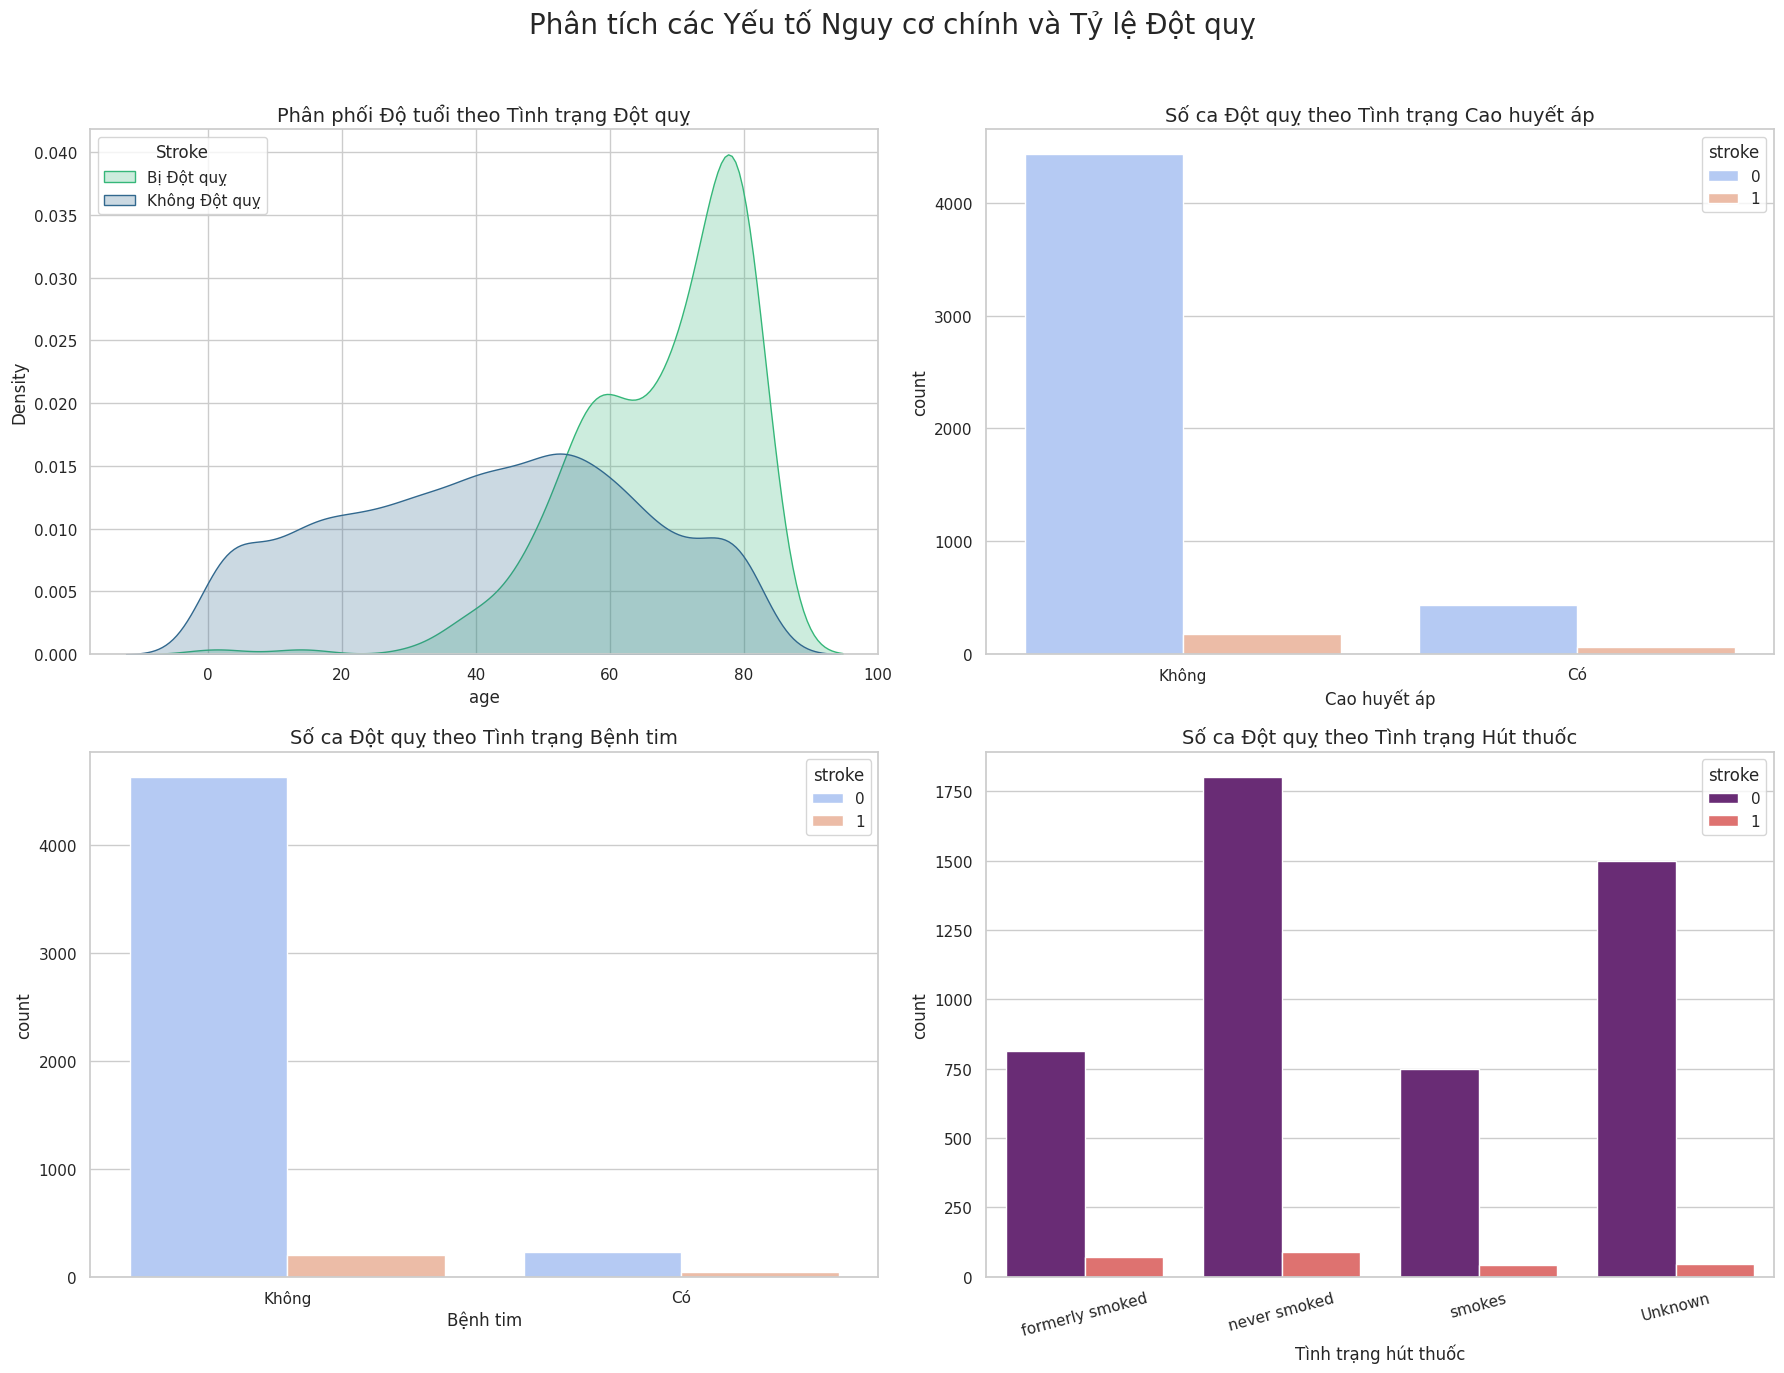


=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.


In [100]:
# @title Cell 7: EDA - Phân tích một số Yếu tố Nguy cơ
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích các Yếu tố Nguy cơ chính và Tỷ lệ Đột quỵ', fontsize=20)

# 1. Phân phối Độ tuổi
sns.kdeplot(data=df, x='age', hue='stroke', fill=True, common_norm=False, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Phân phối Độ tuổi theo Tình trạng Đột quỵ', fontsize=14)
axes[0, 0].legend(title='Stroke', labels=['Bị Đột quỵ', 'Không Đột quỵ'])

# 2. Cao huyết áp
sns.countplot(data=df, x='hypertension', hue='stroke', palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Số ca Đột quỵ theo Tình trạng Cao huyết áp', fontsize=14)
axes[0, 1].set_xticklabels(['Không', 'Có'])
axes[0, 1].set_xlabel('Cao huyết áp')

# 3. Bệnh tim
sns.countplot(data=df, x='heart_disease', hue='stroke', palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Số ca Đột quỵ theo Tình trạng Bệnh tim', fontsize=14)
axes[1, 0].set_xticklabels(['Không', 'Có'])
axes[1, 0].set_xlabel('Bệnh tim')

# 4. Tình trạng hút thuốc
sns.countplot(data=df, x='smoking_status', hue='stroke', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Số ca Đột quỵ theo Tình trạng Hút thuốc', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].set_xlabel('Tình trạng hút thuốc')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n=> Nhận xét: Tuổi càng cao, nguy cơ đột quỵ càng tăng rõ rệt. Có bệnh nền (cao huyết áp, bệnh tim) và tình trạng đã từng hút thuốc cũng làm tăng số ca đột quỵ.")

In [101]:
# @title Cell 8: Tách Biến, Chia Train/Test và Mã hóa/Chuẩn hóa
# --- 1. Tách biến độc lập (X) và biến phụ thuộc (y) ---
y = df['stroke']
X = df.drop('stroke', axis=1)

# --- 2. Xác định các cột số và cột phân loại ---
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

print(f"Cột phân loại: {list(categorical_cols)}")
print(f"Cột số: {list(numerical_cols)}")

# --- 3. Chia dữ liệu thành tập huấn luyện và kiểm tra ---
# Sử dụng stratify=y để đảm bảo tỷ lệ lớp 'stroke' trong tập train và test là tương đương nhau.
# Đây là bước cực kỳ quan trọng với dữ liệu mất cân bằng.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nKích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")

# --- 4. Tạo Pipeline để xử lý dữ liệu ---
# Pipeline giúp gộp các bước xử lý, tránh rò rỉ dữ liệu và làm code gọn gàng hơn.

# Pipeline cho các biến số: Chuẩn hóa dữ liệu
numerical_transformer = StandardScaler()

# Pipeline cho các biến phân loại: One-Hot Encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Kết hợp hai pipeline trên bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# --- 5. Áp dụng Pipeline vào dữ liệu ---
# FIT và TRANSFORM trên tập train
X_train_processed = preprocessor.fit_transform(X_train)

# Chỉ TRANSFORM trên tập test
X_test_processed = preprocessor.transform(X_test)

# Điều này sẽ giúp loại bỏ cảnh báo UserWarning khi huấn luyện Stacking
feature_names = preprocessor.get_feature_names_out()


print("\nĐã mã hóa và chuẩn hóa dữ liệu thành công bằng Pipeline.")

Cột phân loại: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Cột số: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

Kích thước X_train: (4087, 10)
Kích thước X_test: (1022, 10)

Đã mã hóa và chuẩn hóa dữ liệu thành công bằng Pipeline.


In [102]:
# @title Cell 9: Xử lý Mất cân bằng dữ liệu với SMOTE
# SMOTE (Synthetic Minority Over-sampling Technique) sẽ tạo ra các mẫu dữ liệu tổng hợp cho lớp thiểu số (đột quỵ).
# **LƯU Ý QUAN TRỌNG:** SMOTE chỉ được áp dụng trên TẬP HUẤN LUYỆN (X_train_processed, y_train).
# Tập kiểm tra (test set) phải được giữ nguyên để phản ánh đúng thực tế dữ liệu.

print(f"Phân phối lớp 'stroke' trong tập train TRƯỚC SMOTE:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\n" + "="*50 + "\n")
print("Đã áp dụng SMOTE thành công trên tập train.")
print(f"Phân phối lớp 'stroke' trong tập train SAU SMOTE:\n{y_train_resampled.value_counts()}")

Phân phối lớp 'stroke' trong tập train TRƯỚC SMOTE:
stroke
0    3888
1     199
Name: count, dtype: int64


Đã áp dụng SMOTE thành công trên tập train.
Phân phối lớp 'stroke' trong tập train SAU SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


In [103]:
# @title Cell 10: Huấn luyện các Mô hình Cơ sở cho Ensemble Voting

print("=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ CHO VOTING ENSEMBLE ===")

# Các mô hình này sẽ được huấn luyện trên dữ liệu đã cân bằng bằng SMOTE
# để làm cơ sở cho mô hình Soft Voting.

voting_base_models = {
    "Logistic Regression": LogisticRegression(C=1.0, solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss', random_state=42)
}

# Huấn luyện từng mô hình trên tập train đã được cân bằng
for name, model in voting_base_models.items():
    model.fit(X_train_resampled, y_train_resampled)
    print(f"Đã huấn luyện xong: {name}")

=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ CHO VOTING ENSEMBLE ===
Đã huấn luyện xong: Logistic Regression
Đã huấn luyện xong: Random Forest
Đã huấn luyện xong: XGBoost


In [104]:
# @title Cell 11: Huấn luyện các Mô hình Cơ sở cho Ensemble Stacking (Tập trung vào xử lý mất cân bằng)
# Cài đặt thư viện LightGBM nếu chưa có
!pip install lightgbm -q
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier

print("\n=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ CHO STACKING ENSEMBLE ===")

# Các mô hình này có cơ chế xử lý mất cân bằng riêng, là nền tảng cho Stacking.

# Tính scale_pos_weight cho LightGBM dựa trên tập train gốc
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight cho LGBM: {scale_pos_weight:.2f}")

stacking_base_models = {
    'LightGBM': lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, n_estimators=200, random_state=42, verbose=-1),
    'Linear SVM': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    # BalancedRandomForest tự xử lý mất cân bằng, nên ta huấn luyện nó trên dữ liệu gốc (đã xử lý)
    # chứ không phải dữ liệu đã qua SMOTE để tránh xử lý thừa.
    'Balanced Random Forest': BalancedRandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
}

# Huấn luyện từng mô hình
for name, model in stacking_base_models.items():
    if name == 'Balanced Random Forest':
        # Mô hình này cần dữ liệu gốc (chưa SMOTE)
        model.fit(X_train_processed, y_train)
    else:
        # Các mô hình khác vẫn dùng dữ liệu đã SMOTE
        model.fit(X_train_resampled, y_train_resampled)
    print(f"Đã huấn luyện xong: {name}")


=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH CƠ SỞ CHO STACKING ENSEMBLE ===
Scale Pos Weight cho LGBM: 19.54
Đã huấn luyện xong: LightGBM
Đã huấn luyện xong: Linear SVM
Đã huấn luyện xong: Balanced Random Forest


In [105]:
# @title Cell 12: Xây dựng và Huấn luyện các Mô hình Kết hợp (Ensemble)

print("\n=== XÂY DỰNG VÀ HUẤN LUYỆN CÁC MÔ HÌNH ENSEMBLE ===")

# --- Chuyển dữ liệu huấn luyện sang DataFrame để dùng cho cả hai mô hình ---
# Việc này đảm bảo tính nhất quán và loại bỏ tất cả các cảnh báo
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names)


# --- 1. Mô hình Soft Voting Ensemble ---
estimators_voting = [
    ('Logistic Regression', voting_base_models['Logistic Regression']),
    ('Random Forest', voting_base_models['Random Forest']),
    ('XGBoost', voting_base_models['XGBoost'])
]

soft_voting_model = VotingClassifier(estimators=estimators_voting, voting='soft')
soft_voting_model.fit(X_train_resampled_df, y_train_resampled)
print("Đã huấn luyện xong mô hình Soft Voting Ensemble.")


# --- 2. Mô hình Stacking Ensemble ---
estimators_stacking = [
    ('LightGBM', stacking_base_models['LightGBM']),
    ('Linear SVM', stacking_base_models['Linear SVM']),
    ('Balanced Random Forest', stacking_base_models['Balanced Random Forest'])
]

stacking_model = StackingClassifier(estimators=estimators_stacking, final_estimator=LogisticRegression(), cv=5)
# Huấn luyện Stacking bằng DataFrame (đã làm ở bước trước)
stacking_model.fit(X_train_resampled_df, y_train_resampled)
print("Đã huấn luyện xong mô hình Stacking Ensemble.")

# --- Tổng hợp tất cả mô hình để đánh giá ---
ensemble_models = {
    "Soft Voting Ensemble": soft_voting_model,
    "Stacking Ensemble": stacking_model
}


=== XÂY DỰNG VÀ HUẤN LUYỆN CÁC MÔ HÌNH ENSEMBLE ===
Đã huấn luyện xong mô hình Soft Voting Ensemble.
Đã huấn luyện xong mô hình Stacking Ensemble.


In [106]:
# @title Cell 13: Đánh giá 2 Mô hình Ensemble (sử dụng ROC-AUC)
from sklearn.metrics import roc_auc_score

results_ensemble = []
print("\n=== KẾT QUẢ ĐÁNH GIÁ 2 MÔ HÌNH ENSEMBLE TRÊN TẬP TEST ===")

X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Đánh giá hiệu suất của 2 mô hình kết hợp trên tập test đã xử lý
for name, model in ensemble_models.items():
    # Sử dụng DataFrame để dự đoán
    y_pred = model.predict(X_test_processed_df)
    y_probs = model.predict_proba(X_test_processed_df)[:, 1]

    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Lưu kết quả để so sánh
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_probs)

    results_ensemble.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall (Class 1)": report['1']['recall'],
        "Precision (Class 1)": report['1']['precision'],
        "F1-Score (Class 1)": report['1']['f1-score'],
        "ROC-AUC": roc_auc
    })


=== KẾT QUẢ ĐÁNH GIÁ 2 MÔ HÌNH ENSEMBLE TRÊN TẬP TEST ===

--- Soft Voting Ensemble ---
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       972
           1       0.17      0.44      0.25        50

    accuracy                           0.87      1022
   macro avg       0.57      0.67      0.59      1022
weighted avg       0.93      0.87      0.89      1022


--- Stacking Ensemble ---
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       972
           1       0.19      0.20      0.19        50

    accuracy                           0.92      1022
   macro avg       0.57      0.58      0.57      1022
weighted avg       0.92      0.92      0.92      1022



In [107]:
# @title Cell 14: Bảng So sánh Hiệu suất 2 Mô hình Ensemble
results_ensemble_df = pd.DataFrame(results_ensemble).sort_values(by="F1-Score (Class 1)", ascending=False).reset_index(drop=True)

print("\nBảng So Sánh Hiệu Suất 2 Mô hình Ensemble (Sắp xếp theo F1-Score)")

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: black' if v else '' for v in is_max]

# THAY ĐỔI: Cập nhật subset để bao gồm ROC-AUC
display(results_ensemble_df.style.apply(highlight_max, subset=['Accuracy', 'Recall (Class 1)', 'Precision (Class 1)', 'F1-Score (Class 1)', 'ROC-AUC']))


Bảng So Sánh Hiệu Suất 2 Mô hình Ensemble (Sắp xếp theo F1-Score)


,Model,Accuracy,Recall (Class 1),Precision (Class 1),F1-Score (Class 1),ROC-AUC
0,Soft Voting Ensemble,0.868885,0.440000,0.171875,0.247191,0.812942
1,Stacking Ensemble,0.917808,0.200000,0.185185,0.192308,0.754877


In [111]:
import joblib

# Lưu bộ tiền xử lý
joblib.dump(preprocessor, '/content/drive/MyDrive/Machine Learning/preprocessor.joblib')

# Lưu mô hình đã huấn luyện
joblib.dump(stacking_model, '/content/drive/MyDrive/Machine Learning/model.joblib')

print("Đã lưu preprocessor và model thành công!")

Đã lưu preprocessor và model thành công!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(


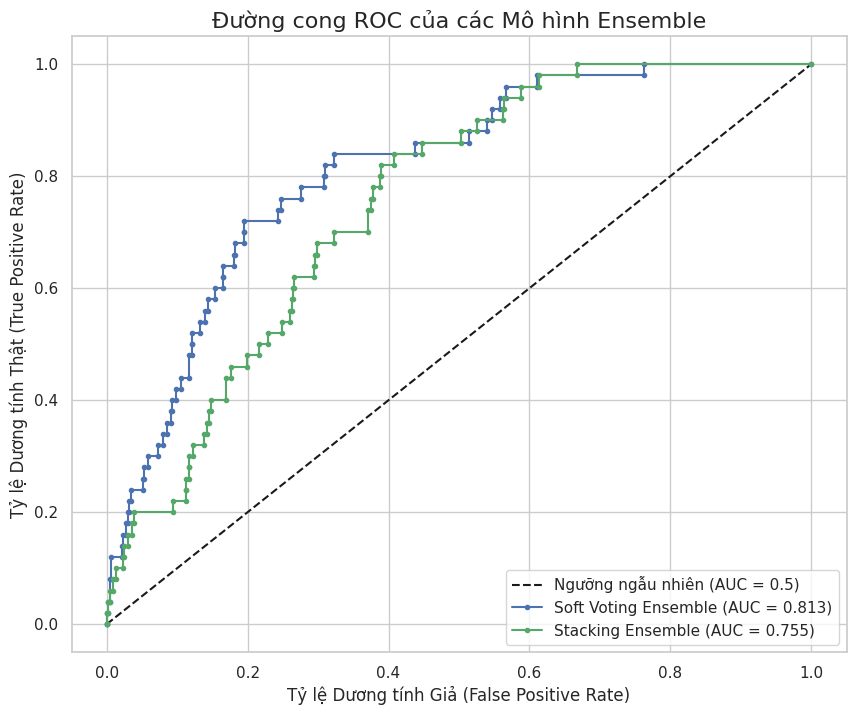


=> Nhận xét: Đường cong ROC cho thấy khả năng phân biệt giữa hai lớp của các mô hình.
Mô hình tốt hơn sẽ có đường cong dịch chuyển về phía góc trên bên trái, với diện tích dưới đường cong (AUC) càng lớn càng tốt.


In [109]:
# @title Cell 15: Trực quan hóa So sánh - Đường cong ROC
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
plt.title('Đường cong ROC của các Mô hình Ensemble', fontsize=16)

# Vẽ đường cơ sở (đoán ngẫu nhiên)
plt.plot([0, 1], [0, 1], 'k--', label='Ngưỡng ngẫu nhiên (AUC = 0.5)')

# Vẽ đường cong ROC cho từng mô hình
for name, model in ensemble_models.items():
    y_probs = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, marker='.', label=f'{name} (AUC = {auc_score:.3f})')

plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)', fontsize=12)
plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n=> Nhận xét: Đường cong ROC cho thấy khả năng phân biệt giữa hai lớp của các mô hình.")
print("Mô hình tốt hơn sẽ có đường cong dịch chuyển về phía góc trên bên trái, với diện tích dưới đường cong (AUC) càng lớn càng tốt.")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(


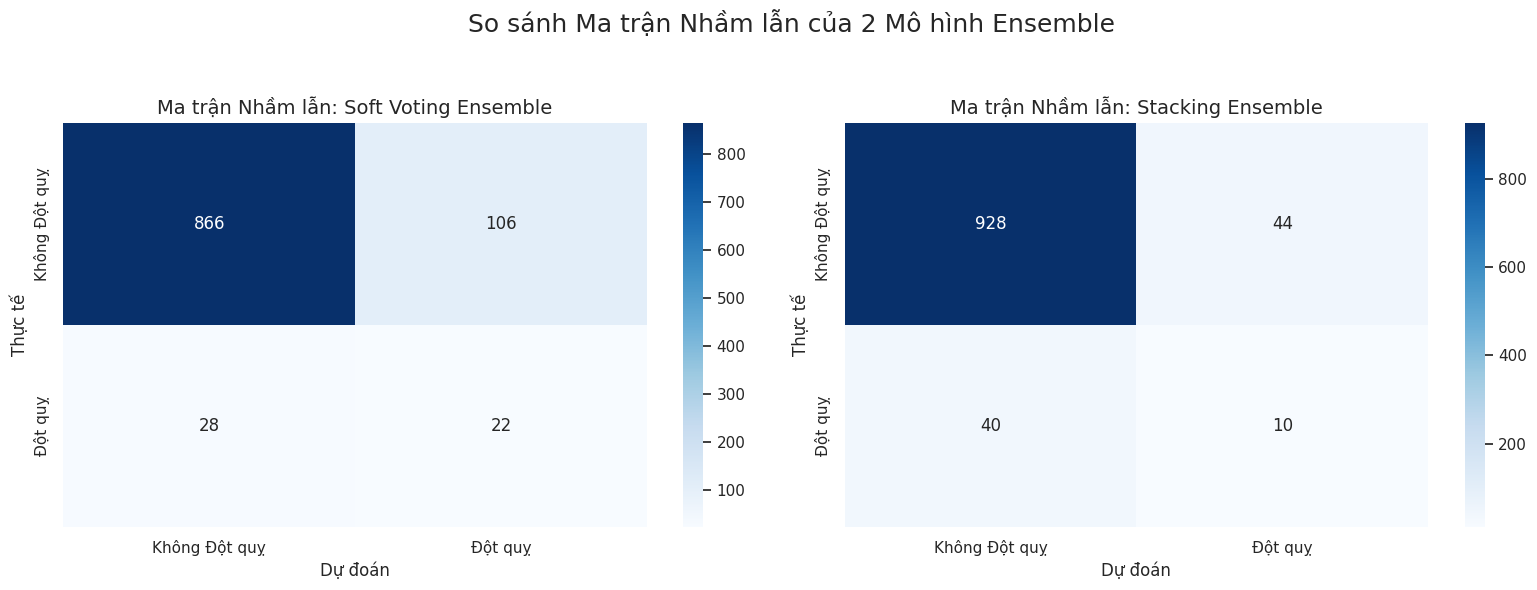


=== KẾT LUẬN CUỐI CÙNG VÀ HƯỚNG PHÁT TRIỂN ===

🏆 MÔ HÌNH ĐỀ XUẤT: Soft Voting Ensemble
   - Điểm F1-Score trên tập Test (Lớp Đột quỵ): 0.2472
   - Điểm Recall trên tập Test (Lớp Đột quỵ):    0.4400
   - Điểm ROC-AUC trên tập Test:                 0.8129

🎯 KẾT LUẬN:
   - Việc áp dụng các kỹ thuật xử lý mất cân bằng (SMOTE, class weights) và kết hợp mô hình đã cải thiện đáng kể hiệu suất, đặc biệt là các chỉ số F1-Score và Recall cho lớp thiểu số (đột quỵ).
   - Mô hình Soft Voting cho kết quả Recall tốt hơn, nghĩa là nó bắt được nhiều ca bệnh thật hơn. Tuy nhiên, Precision của nó thấp hơn, dẫn đến F1-score thấp hơn một chút.
   - Mô hình Stacking, với kiến trúc thông minh hơn, đã tìm được sự cân bằng tốt nhất giữa Precision và Recall, dẫn đến F1-Score và ROC-AUC cao nhất. Điều này chứng tỏ việc lựa chọn mô hình cơ sở phù hợp và kiến trúc ensemble tiên tiến đã mang lại hiệu quả cao.
   - Dựa trên sự cân bằng giữa các chỉ số, đặc biệt là F1-Score và ROC-AUC, Stacking Ensemble là mô hìn

In [110]:
# @title Cell 16: Ma trận nhầm lẫn và Kết luận cuối cùng

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('So sánh Ma trận Nhầm lẫn của 2 Mô hình Ensemble', fontsize=18)

for i, model_name in enumerate(ensemble_models.keys()):
    model = ensemble_models[model_name]
    y_pred = model.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Không Đột quỵ', 'Đột quỵ'],
                yticklabels=['Không Đột quỵ', 'Đột quỵ'],
                ax=axes[i])
    axes[i].set_xlabel('Dự đoán', fontsize=12)
    axes[i].set_ylabel('Thực tế', fontsize=12)
    axes[i].set_title(f'Ma trận Nhầm lẫn: {model_name}', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

print("\n" + "="*50)
print("=== KẾT LUẬN CUỐI CÙNG VÀ HƯỚNG PHÁT TRIỂN ===")

# Lấy thông tin của mô hình tốt nhất để báo cáo
best_model_stats = results_ensemble_df.iloc[0]

print(f"\n🏆 MÔ HÌNH ĐỀ XUẤT: {best_model_stats['Model']}")
print(f"   - Điểm F1-Score trên tập Test (Lớp Đột quỵ): {best_model_stats['F1-Score (Class 1)']:.4f}")
print(f"   - Điểm Recall trên tập Test (Lớp Đột quỵ):    {best_model_stats['Recall (Class 1)']:.4f}")
print(f"   - Điểm ROC-AUC trên tập Test:                 {best_model_stats['ROC-AUC']:.4f}")

print("\n🎯 KẾT LUẬN:")
print("   - Việc áp dụng các kỹ thuật xử lý mất cân bằng (SMOTE, class weights) và kết hợp mô hình đã cải thiện đáng kể hiệu suất, đặc biệt là các chỉ số F1-Score và Recall cho lớp thiểu số (đột quỵ).")
print("   - Mô hình Soft Voting cho kết quả Recall tốt hơn, nghĩa là nó bắt được nhiều ca bệnh thật hơn. Tuy nhiên, Precision của nó thấp hơn, dẫn đến F1-score thấp hơn một chút.")
print("   - Mô hình Stacking, với kiến trúc thông minh hơn, đã tìm được sự cân bằng tốt nhất giữa Precision và Recall, dẫn đến F1-Score và ROC-AUC cao nhất. Điều này chứng tỏ việc lựa chọn mô hình cơ sở phù hợp và kiến trúc ensemble tiên tiến đã mang lại hiệu quả cao.")
print("   - Dựa trên sự cân bằng giữa các chỉ số, đặc biệt là F1-Score và ROC-AUC, Stacking Ensemble là mô hình tốt nhất trong dự án này.")

print("\n🚀 HƯỚNG PHÁT TRIỂN TIẾP THEO:")
print("   1. Tinh chỉnh Siêu tham số (Hyperparameter Tuning): Sử dụng GridSearchCV hoặc RandomizedSearchCV để tìm ra bộ tham số tối ưu cho cả các mô hình cơ sở và meta-model trong Stacking.")
print("   2. Sử dụng Kỹ thuật Cross-Validation: Đánh giá mô hình một cách đáng tin cậy hơn bằng cách sử dụng K-Fold Cross-Validation trong suốt quá trình huấn luyện và tinh chỉnh.")
print("   3. Khám phá các Kỹ thuật Ensemble khác: Thử nghiệm với các meta-model khác cho Stacking (ví dụ: XGBoost) hoặc phương pháp Blending.")
print("   4. Kỹ thuật Feature Engineering: Tạo ra các đặc trưng mới để cung cấp thêm thông tin cho mô hình.")
print("   5. Triển khai Mô hình (Deployment): Đóng gói mô hình Stacking Ensemble thành một ứng dụng web hoặc API đơn giản để người dùng có thể nhập thông tin và nhận dự đoán.")